## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams. 

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1. 

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [2]:
import pickle
with open('data/all_tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)
    
from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

print("Top 20 tokens:")
for token, count in token_count.most_common(20):
    print(f"{token}: {count}")

Top 20 tokens:
new: 1365
date: 1202
get: 1052
please: 1022
enron: 927
like: 923
2002: 869
would: 806
one: 798
message: 795
call: 740
free: 691
software: 680
dear: 651
know: 644
email: 629
url:: 625
time: 609
start: 604
linguistics: 598


Plot a histogram of the occurrences of tokens. 

What do you notice about the frequency of occurrence of different tokens? How does it look?

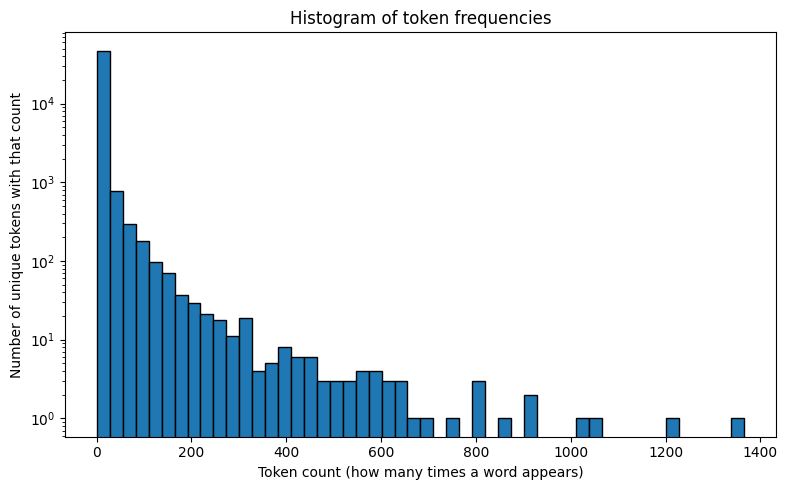

In [4]:
import matplotlib.pyplot as plt
frequencies = list(token_count.values())
plt.figure(figsize=(8,5))
plt.hist(frequencies, bins=50, edgecolor='black')
plt.xlabel("Token count (how many times a word appears)")
plt.ylabel("Number of unique tokens with that count")
plt.yscale('log')
plt.title("Histogram of token frequencies")
plt.tight_layout()
plt.show()

The histogram of token frequencies is extremely skewed, with the majority of values falling in the 0 to 100 range, and very few outside of that. This is because while a few tokens appear a lot, most tokens only appear once or only a few times.

### Q2. 

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions? 

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np

# 1
df = pd.read_parquet("./data/Phishing_clean.parquet")

y = df["Email Type"]

X = df.drop(columns=["Email Type"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

# 2
model = LinearRegression()
model.fit(X_train, y_train)

# R^2 on training set
r2_train = model.score(X_train, y_train)

# R^2 on test set
r2_test = model.score(X_test, y_test)

print(f"Training R^2: {r2_train:.4f}")
print(f"Test R^2:     {r2_test:.4f}")

# 3
coefs = pd.Series(model.coef_, index=X.columns)

coefs_abs = coefs.abs().sort_values(ascending=False)

top_k = 5
print("\nTop 5 words by coefficient:")
for word in coefs_abs.head(top_k).index:
    print(f"{word:25s} coef = {coefs[word]:.4f}")


Training R^2: 0.7670
Test R^2:     0.6659

Top 5 words by coefficient:
intervention              coef = -1.2593
localized                 coef = 0.8244
thermal                   coef = 0.7470
crawler                   coef = 0.6962
background-image:         coef = -0.6229


The R^2 on the test set is 0.6659, while the R^2 on the training set is 0.7670. The words that have the largest coefficients in absolute value are intervention, localized, thermal, crawler, and background-image.

### Q3. 

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

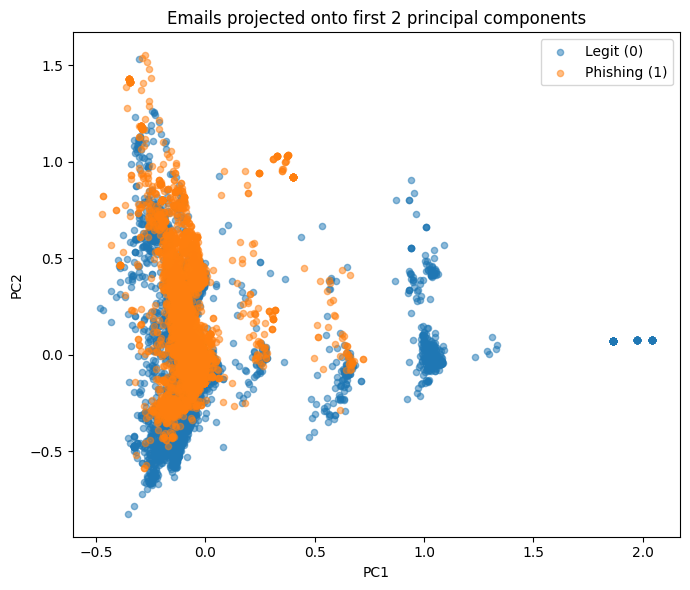

In [13]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load data
df = pd.read_parquet("./data/Phishing_clean.parquet")

# Split into X (features) and y (label)
y = df["Email Type"]              # 1 = phishing, 0 = legit
X = df.drop(columns=["Email Type"])  # one-hot word indicators

# Run PCA for 2 components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    "PC1": X_pca[:, 0],
    "PC2": X_pca[:, 1],
    "Email Type": y.values
})

# 4. Scatter plot of PC1 vs PC2, colored by phishing or not
plt.figure(figsize=(7,6))

phish_mask = pca_df["Email Type"] == 1
legit_mask = pca_df["Email Type"] == 0

plt.scatter(
    pca_df.loc[legit_mask, "PC1"],
    pca_df.loc[legit_mask, "PC2"],
    label="Legit (0)",
    alpha=0.5,
    s=20
)

plt.scatter(
    pca_df.loc[phish_mask, "PC1"],
    pca_df.loc[phish_mask, "PC2"],
    label="Phishing (1)",
    alpha=0.5,
    s=20
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Emails projected onto first 2 principal components")
plt.legend()
plt.tight_layout()
plt.show()


Looking at the scatter plot, there are a few patterns. From the plot, phishing and legitimate emails overlap a lot in the main cluster on the left (so they often use similar language), but there are also smaller clusters to the right that are almost entirely legitimate emails, which suggests that some groups of normal emails share vocabulary that phishing emails basically never use.

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

df = pd.read_parquet("./data/Phishing_clean.parquet")

y = df["Email Type"]
X = df.drop(columns=["Email Type"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

pca = PCA(n_components=2610, random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_test_pca  = pca.transform(X_test)

model = LinearRegression()
model.fit(X_train_pca, y_train)

r2_train = model.score(X_train_pca, y_train)
r2_test = model.score(X_test_pca, y_test)

print(f"Training R^2: {r2_train:.4f}")
print(f"Test R^2:     {r2_test:.4f}")

Training R^2: 0.7662
Test R^2:     0.6683


The R^2 on the training set is 0.7662, while the R^2 on the test set is 0.6683. The R^2 for the training set is is slightly lower than the original full linear regression (because it can’t overfit as hard), but its test R^2 is similar or slightly higher, which means PCA helps generalization by removing some of the noisy token dimensions.

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Using principal components lets us keep most of the real signal in the emails while throwing away a lot of noisy/redundant dimensions, so the model can’t just memorize the training set. In other words, PCA turns thousands of highly correlated word indicators into a smaller set of uncorrelated features that capture the main patterns, which makes the regression more stable, less overfit, and better at generalizing to new emails.